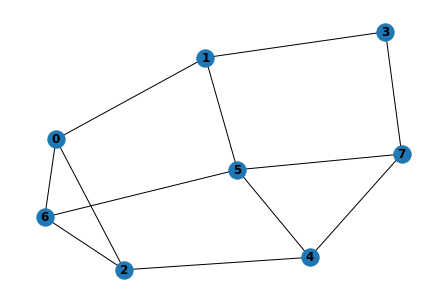

In [19]:
from mindquantum.core import Circuit, Hamiltonian, UN, H, ZZ, RX, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import Simulator
import networkx as nx
import mindspore.nn as nn

# 构图
g = nx.Graph()
nx.add_path(g, [0, 1])
nx.add_path(g, [0, 2])
nx.add_path(g, [1, 3])
nx.add_path(g, [2, 4])
nx.add_path(g, [4, 5])
nx.add_path(g, [4, 7])
nx.add_path(g, [5, 6])
nx.add_path(g, [6, 2])
nx.add_path(g, [7, 4])
nx.add_path(g, [1, 5])
nx.add_path(g, [0, 6])
nx.add_path(g, [5, 7])
nx.add_path(g, [7, 3])
nx.draw(g, with_labels=True, font_weight='bold')

In [20]:
# 搭建UC(γ)对应的量子线路, 对图中的每条边作用ZZ门
def build_hc(g, para):
    hc = Circuit()
    for i in g.edges:
        hc += ZZ(para).on(i)
    hc.barrier()
    return hc
    
# 搭建UB(β)对应的量子线路, 对每个节点作用RX门
def build_hb(g, para):
    hb = Circuit()
    for i in g.nodes:
        hb += RX(para).on(i)
    hb.barrier()
    return hb

# 搭建多层的训练网络
# g是max-cut问题的图，p是ansatz线路的层数
def build_ansatz(g, p):                    
    circ = Circuit()
    for i in range(p):
        circ += build_hc(g, f'g{i}')
        circ += build_hb(g, f'b{i}')
    return circ

# 构建图对应的哈密顿量HC
def build_ham(g):
    ham = QubitOperator()
    for i in g.edges:
        ham += QubitOperator(f'Z{i[0]} Z{i[1]}')
    return ham

In [21]:
p = 4
# 生成哈密顿量
ham = Hamiltonian(build_ham(g))
# 生成均匀叠加态，即对所有量子比特作用H门
init_state_circ = UN(H, g.nodes)
# 生成ansatz线路
ansatz = build_ansatz(g, p)
# 将初始化线路与ansatz线路组合成一个线路
circ = init_state_circ + ansatz

import mindspore as ms
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

# 创建模拟器，backend使用‘projectq’，能模拟5个比特（'circ'线路中包含的比特数）
sim = Simulator('projectq', circ.n_qubits)              # 获取计算变分量子线路的期望值和梯度的算子
grad_ops = sim.get_expectation_with_grad(ham, circ)     # 生成待训练的神经网络
net = MQAnsatzOnlyLayer(grad_ops)                       
# 设置针对网络中所有可训练参数、学习率为0.05的Adam优化器
opti = nn.Adam(net.trainable_params(), learning_rate=0.05)
# 对神经网络进行一步训练
train_net = nn.TrainOneStepCell(net, opti)    

In [22]:
 # 将神经网络训练一步并计算得到的结果（切割边数）
for i in range(200):
    cut = (len(g.edges) - train_net()) / 2
    if i%10 == 0:
        print("train step:", i, ", cut:", cut) 

train step: 0 , cut: [5.9926515]
train step: 10 , cut: [8.163718]
train step: 20 , cut: [8.485587]
train step: 30 , cut: [8.586748]
train step: 40 , cut: [8.65484]
train step: 50 , cut: [8.744768]
train step: 60 , cut: [8.894432]
train step: 70 , cut: [9.180506]
train step: 80 , cut: [9.369743]
train step: 90 , cut: [9.415529]
train step: 100 , cut: [9.422065]
train step: 110 , cut: [9.42565]
train step: 120 , cut: [9.4268675]
train step: 130 , cut: [9.427852]
train step: 140 , cut: [9.427977]
train step: 150 , cut: [9.427997]
train step: 160 , cut: [9.428017]
train step: 170 , cut: [9.428025]
train step: 180 , cut: [9.42803]
train step: 190 , cut: [9.42803]


In [23]:
 # 获取线路参数
pr = dict(zip(ansatz.params_name, net.weight.asnumpy()))
# 为线路中所有比特添加测量门
circ.measure_all()
# 运行线路1000次并打印结果
sim.sampling(circ, pr=pr, shots=1000)

shots: 1000
Keys: q7 q6 q5 q4 q3 q2 q1 q0│0.00   0.044       0.088       0.132       0.176        0.22
─────────────────────────────┼───────────┴───────────┴───────────┴───────────┴───────────┴
                     00000110│▒
                             │
                     00001100│▒
                             │
                     00001110│▒
                             │
                     00001111│▒
                             │
                     00011000│▒
                             │
                     00011001│▒▒
                             │
                     00100101│▒
                             │
                     00100110│▒▒
                             │
                     00100111│▒
                             │
                     00101001│▒
                             │
                     00101010│▒
                             │
                     00101100│▒▒▒▒
                             │
                     00101101│▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒
                             │
                     00101110│▒
                             │
                     00101111│▒
                             │
                     00110001│▒
                             │
                     00110101│▒
                             │
                     00111000│▒
                             │
                     00111001│▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒
                             │
                     00111011│▒
                             │
                     00111100│▒
                             │
                     00111101│▒
                             │
                     00111110│▒
                             │
                     00111111│▒
                             │
                     01000111│▒
                             │
                     01001000│▒
                             │
                     01001110│▒
                             │
                     01010010│▒▒▒▒▒▒
                             │
                     01010011│▒▒
                             │
                     01010110│▒
                             │
                     01011001│▒▒▒▒▒▒▒▒▒▒▒▒▒
                             │
                     01011010│▒▒▒▒▒▒▒▒▒▒▒▒▒▒
                             │
                     01011011│▒
                             │
                     01011100│▒
                             │
                     01011101│▒
                             │
                     01011110│▒▒
                             │
                     01101001│▒
                             │
                     01101100│▒
                             │
                     01101111│▒
                             │
                     01110010│▒
                             │
                     01110011│▒
                             │
                     01111000│▒▒
                             │
                     01111001│▒▒▒▒▒▒
                             │
                     10000001│▒
                             │
                     10000100│▒
                             │
                     10000110│▒▒▒▒▒▒
                             │
                     10000111│▒
                             │
                     10001010│▒
                             │
                     10010001│▒
                             │
                     10010010│▒
                             │
                     10010011│▒
                             │
                     10100001│▒▒
                             │
                     10100100│▒
                             │
                     10100101│▒▒▒▒▒▒▒▒▒▒
                             │
                     10100110│▒▒▒▒▒▒▒▒▒▒▒▒
                             │
                     10100111│▒
                             │
                     10101001│▒
                             │
                     10101100│▒
                             │
     

In [37]:
# 枚举可能的情况
def dfs(pos, stat):
    if pos >= len(g.nodes):
        res = nx.cut_size(g, stat)
        if res >= 10:
            print('stat:', stat, 'cut=', res)
        return
    stat.append(pos)
    dfs(pos + 1, stat)
    stat.pop()
    dfs(pos + 1, stat)
    
dfs(0, [])


stat: [0, 2, 3, 5] cut= 10
stat: [0, 3, 4, 5] cut= 10
stat: [1, 2, 6, 7] cut= 10
stat: [1, 4, 6, 7] cut= 10


In [ ]:
"""
 近似算法得到的近似最大解为 9.42803，可知实际的最大割因不小于 10
 穷举法得到的最大割为 10，如果对节点分组的左右进行区分，则一共有 4 种分组方法可以使切割边数最大。
 二进制分组表示分别为:
  11010010, 11000110, 00111001, 00101101
在 1000 次测量得到的解集中，这些解出现的频数分别为:
  176 131 120 171

可以看出近似算法的表现还是不错的
"""